In [1]:
#Importing required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

%matplotlib inline

In [ ]:
from londonbss.ml_logic.main2 import preprocess, train, evaluate, processing, processing_pred
from londonbss.ml_logic.features  import get_raw_features
from londonbss.ml_logic.registry import load_model
from londonbss.ml_logic.preproc import fit_transform_features
from londonbss.ml_logic.model import test_adf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from londonbss.params import *

In [ ]:
file_path = '../../../raw_data/processed/'
station_name = 'wormwood_street__liverpool_street'

In [ ]:
df= pd.read_csv(file_path+f'processed_all_{station_name}_2020-01-01_2023-06-19_full_data_4.csv')

In [ ]:
series = TimeSeries.from_dataframe(df, time_col='startdate', value_cols=station_name,
                                   fill_missing_dates=True, freq='H', fillna_value=0)

In [ ]:
plt.figure(figsize=(20, 5))
series.plot(c='b',linewidth=0.5)

In [ ]:
train, val = series.split_before(pd.Timestamp('20221231'))
plt.figure(figsize=(20, 5))
train.plot(linewidth=0.5, label='Train')
test.plot(linewidth=0.5, label='Test')

In [ ]:
plt.figure(figsize=(20, 5))
(series / 0.5).add_datetime_attribute("day").plot(linewidth=1)

In [ ]:
plt.figure(figsize=(20, 5))
(series / 10).add_holidays("UK").plot(linewidth=1)

In [ ]:
from darts.models import NaiveSeasonal

In [ ]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(test))

In [ ]:
plt.figure(figsize=(20, 5))
series.plot(linewidth=1,label="actual")
naive_forecast.plot(linewidth=1,label="naive forecast (K=1)")

In [ ]:
plt.figure(figsize=(20, 5))
series[-168:].plot(linewidth=1,label="actual")
naive_forecast[-168:].plot(linewidth=1,label="naive forecast (K=1)")

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality
plot_acf(train, m=24, alpha=0.05)

In [ ]:
try_periods = []
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
        try_periods.append(period)

In [ ]:
seasonal_model = NaiveSeasonal(K=24)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test))

In [ ]:
plt.figure(figsize=(20, 5))
series[-168:].plot(linewidth=1, label="actual")
seasonal_forecast[-168:].plot(linewidth=1, label="naive forecast (K=24)")

In [ ]:
combined_forecast = seasonal_forecast - train.last_value()

In [ ]:
from darts.metrics import mae

print(
    "Mean absolute error for the combined naive seasonal: {:.2f}%.".format(
        mae(series, combined_forecast)
    )
)

In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAE: {:.2f}%".format(model, mae(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())

In [ ]:
best_tbats_model = TBATS(seasonal_periods=[24])
best_tbats_model.fit(train)
pred_best_tbats = best_tbats_model.predict(len(val))

In [ ]:
print("model {} obtains MAE: {:.2f}%".format(best_tbats_model, mae(val, pred_best_tbats)))

In [ ]:
plt.figure(figsize=(20, 5))
train.plot(linewidth=1, label="train")
val.plot(linewidth=1, label="true")
pred_best_tbats.plot(linewidth=1, label="prediction")

In [ ]:
plt.figure(figsize=(20, 5))
val[-168:].plot(linewidth=1, label="true")
pred_best_tbats[-168:].plot(linewidth=1, label="prediction")

In [ ]:
# historical_fcast_tbats = best_tbats_model.historical_forecasts(
#     series, start=0.6, forecast_horizon=3, verbose=True
# )

# series[-168:].plot(label="data")
# historical_fcast_tbats[-168:].plot(label="backtest 3-months ahead forecast (Theta)")

In [ ]:
covariates = ['elisabeth_line', 'lockdown','strike', 'school_holidays', 'daytime', 'London_zone_Central',
       'London_zone_North', 'London_zone_West', 'London_zone_South_West',
       'London_zone_South_East', 'London_zone_East', 'Event', 'temperature',
       'rainfall', 'snowfall', 'cloudcover', 'wind_speed', 'wind_direction',
       'year', 'month', 'day', 'hour', 'weekday']

In [ ]:
cov_series = TimeSeries.from_dataframe(df, time_col='startdate', 
                                       value_cols=covariates, 
                                       fill_missing_dates=True, freq='H', fillna_value=0)

In [ ]:
plt.figure(figsize=(20, 5))
cov_series[-168:]['daytime'].plot(linewidth=1, label="true")
series[-168:].plot(linewidth=1, label="prediction")

In [2]:
from darts.models import NBEATSModel

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [ ]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    train,
    past_covariates=cov_series,
    epochs=50,
    verbose=True,
)

In [ ]:
pred = model.predict(series=train, n=len(val))

In [ ]:
plt.figure(figsize=(20, 5))
series[-168:].plot(linewidth=1, label="true")
pred[-168:].plot(linewidth=1, label="pred")

In [ ]:
model.save("my_model.pkl")

In [3]:
model_loaded = NBEATSModel.load("my_model.pkl")

In [4]:
pred = model_loaded.predict(n=24)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='startdate'>

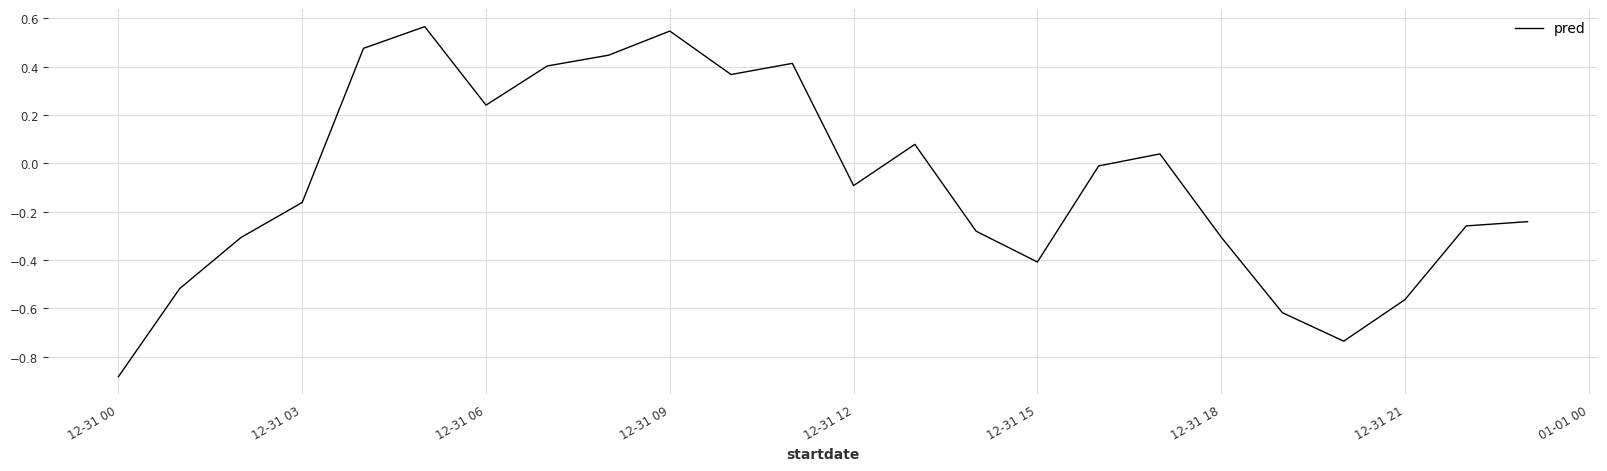

In [5]:
plt.figure(figsize=(20, 5))
pred.plot(linewidth=1, label="pred")

In [12]:
pred.all_values().ravel()

array([-0.88238612, -0.51800847, -0.30660272, -0.16150594,  0.47621767,
        0.5659282 ,  0.24120637,  0.40325885,  0.44773258,  0.54765918,
        0.36787999,  0.4140094 , -0.09169027,  0.0788732 , -0.28053983,
       -0.40791676, -0.01038141,  0.03933211, -0.3051037 , -0.61788266,
       -0.73558494, -0.56348254, -0.25860502, -0.24101983])